#Import and Download Source

In [ ]:
from google.colab import userdata
import os
from os import path

from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from prophet import Prophet
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm
import matplotlib.pyplot as plt
from random import sample
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model

import warnings
warnings.filterwarnings(action="ignore")

Mounted at /content/drive


In [ ]:
def pack(x):
  weekly_pattern_list = []
  for i in tqdm(range(0,1680,7)):
    scaler = MinMaxScaler()
    scaling = scaler.fit_transform(x[i:i+7].values.reshape(-1,1))
    scaling = [y[0]+1 for y in scaling]
    weekly_pattern_list.append(scaling)
  return weekly_pattern_list

In [ ]:
def MAPE(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"bajastephanus","key":"f4015ef0eb80de1117fa920fab48e7c8"}'}

In [ ]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c store-sales-time-series-forecasting
!unzip "/content/store-sales-time-series-forecasting.zip"

 42% 9.00M/21.4M [00:00<00:00, 91.5MB/s]
100% 21.4M/21.4M [00:00<00:00, 125MB/s] 
Archive:  /content/store-sales-time-series-forecasting.zip
  inflating: holidays_events.csv     
  inflating: oil.csv                 
  inflating: sample_submission.csv   
  inflating: stores.csv              
  inflating: test.csv                
  inflating: train.csv               
  inflating: transactions.csv        


#Extract

In [ ]:
df = pd.read_csv("/content/train.csv")
df.head()

id        date  store_nbr      family  sales  onpromotion
0   0  2013-01-01          1  AUTOMOTIVE    0.0            0
1   1  2013-01-01          1   BABY CARE    0.0            0
2   2  2013-01-01          1      BEAUTY    0.0            0
3   3  2013-01-01          1   BEVERAGES    0.0            0
4   4  2013-01-01          1       BOOKS    0.0            0

In [ ]:
df.store_nbr.unique()

array([ 1, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,  2, 20, 21, 22, 23, 24,
       25, 26, 27, 28, 29,  3, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39,  4,
       40, 41, 42, 43, 44, 45, 46, 47, 48, 49,  5, 50, 51, 52, 53, 54,  6,
        7,  8,  9])

In [ ]:
df.family.unique()

array(['AUTOMOTIVE', 'BABY CARE', 'BEAUTY', 'BEVERAGES', 'BOOKS',
       'BREAD/BAKERY', 'CELEBRATION', 'CLEANING', 'DAIRY', 'DELI', 'EGGS',
       'FROZEN FOODS', 'GROCERY I', 'GROCERY II', 'HARDWARE',
       'HOME AND KITCHEN I', 'HOME AND KITCHEN II', 'HOME APPLIANCES',
       'HOME CARE', 'LADIESWEAR', 'LAWN AND GARDEN', 'LINGERIE',
       'LIQUOR,WINE,BEER', 'MAGAZINES', 'MEATS', 'PERSONAL CARE',
       'PET SUPPLIES', 'PLAYERS AND ELECTRONICS', 'POULTRY',
       'PREPARED FOODS', 'PRODUCE', 'SCHOOL AND OFFICE SUPPLIES',
       'SEAFOOD'], dtype=object)

In [ ]:
df_total = df.groupby(['store_nbr','date']).agg({'sales':'sum'}).reset_index()
df_total.head()

store_nbr        date        sales
0          1  2013-01-01     0.000000
1          1  2013-01-02  7417.148000
2          1  2013-01-03  5873.244001
3          1  2013-01-04  5919.879001
4          1  2013-01-05  6318.785010

In [ ]:
px.line(df_total,
        x="date",
        y="sales",
        color='store_nbr')

In [ ]:
df_store = df_total[df_total['store_nbr'] == 1]

In [ ]:
date_list = pd.date_range(df_store.min()['date'], df_store.max()['date'], freq='D')
date_df = pd.DataFrame({'date':date_list})
date_df.head()

date
0 2013-01-01
1 2013-01-02
2 2013-01-03
3 2013-01-04
4 2013-01-05

In [ ]:
df_store['date'] = pd.to_datetime(df_store['date'])
date_df['date'] = pd.to_datetime(date_df['date'])

In [ ]:
df_store = pd.merge(date_df,df_store,on='date',how='left')
df_store.fillna(0,inplace=True)

In [ ]:
df_store.isnull().sum()

date         0
store_nbr    0
sales        0
dtype: int64

#EDA

In [ ]:
px.line(df_store,
        x="date",
        y="sales")

In [ ]:
coeff_list = []
for lag in range(1,1000):
  coeff = np.corrcoef(df_store.sales[lag:],df_store.sales.shift(lag)[lag:])[0,1]
  coeff_list.append(coeff)
px.line(x=range(1,1000),y=coeff_list)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpzr6ze4_d/i7d6t9gd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpzr6ze4_d/582asgun.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=97569', 'data', 'file=/tmp/tmpzr6ze4_d/i7d6t9gd.json', 'init=/tmp/tmpzr6ze4_d/582asgun.json', 'output', 'file=/tmp/tmpzr6ze4_d/prophet_model9wfv3ffg/prophet_model-20240628061508.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:15:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:15:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


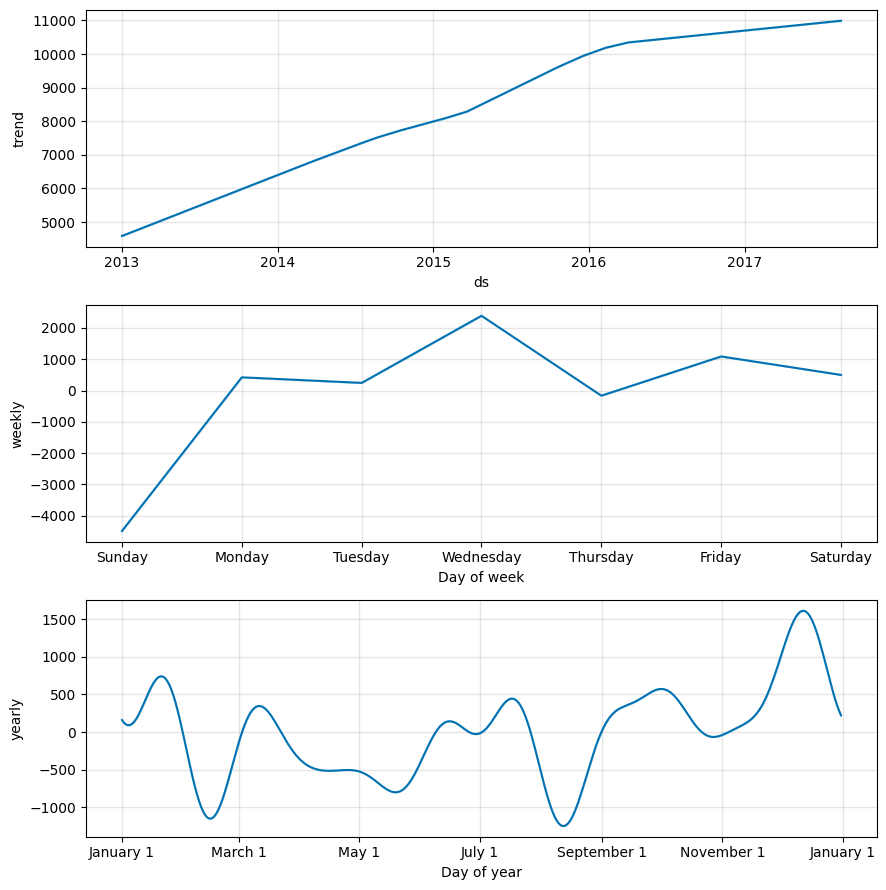

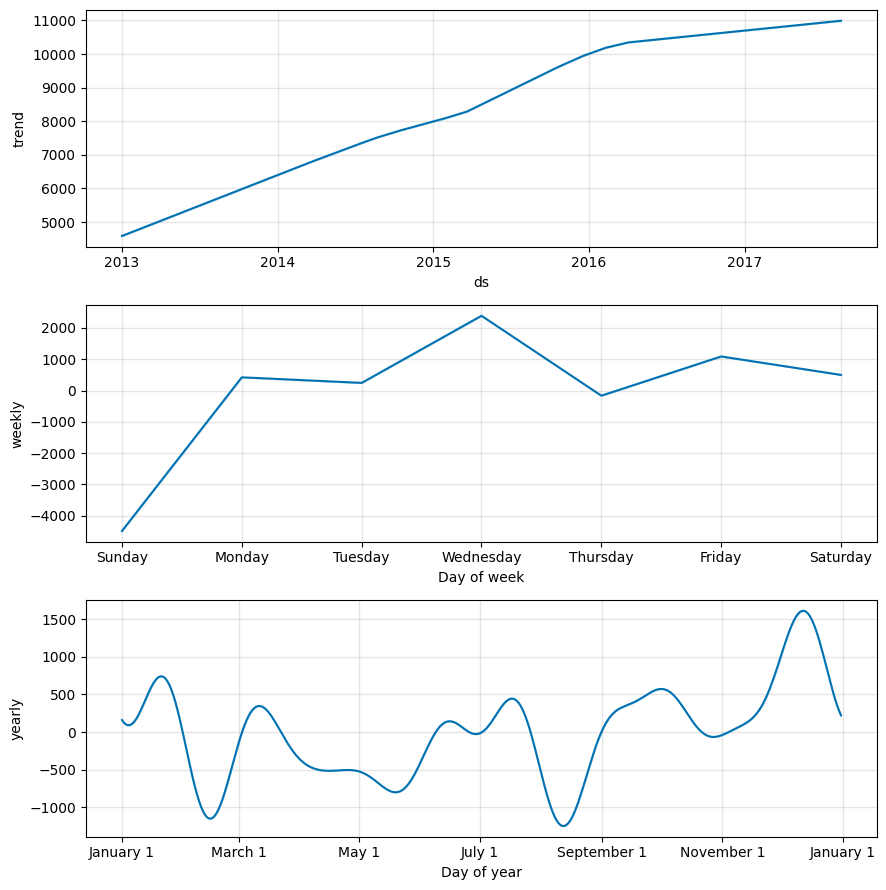

In [ ]:
model = Prophet(weekly_seasonality = 6)
model.fit(df_store.rename(columns={'date':'ds','sales':'y'})[['ds','y']])

future = model.make_future_dataframe(periods=0)
forecast = model.predict(future)

model.plot_components(forecast)

In [ ]:
fig = go.Figure()
fig.add_traces(go.Scatter(x=forecast.ds, y=forecast.yhat, name='forecast', mode='markers'))
fig.add_traces(go.Scatter(x=df_store.date, y=df_store.sales, name='actual'))
fig.add_traces(go.Scatter(x=forecast.ds, y=forecast.yhat_lower, name='lower'))
fig.add_traces(go.Scatter(x=forecast.ds, y=forecast.yhat_upper, name='upper',fill='tonexty'))
fig.add_traces(go.Scatter(x=forecast.ds, y=forecast.yearly_upper, name='yearly'))
fig.update_layout(title='Forecast vs Actual',
                  xaxis_title='Date',
                  yaxis_title='Sales')
fig.show()

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=forecast[:1680]['ds'],y=forecast[:1680]['weekly']))
fig.add_trace(go.Scatter(x=df_store[:1680].date,y=df_store[:1680].sales))
fig.update_layout(title='Forecast vs Actual',
                  xaxis_title='Date',
                  yaxis_title='Sales')
fig.show()

In [ ]:
weekly_pattern = forecast[0:7]['weekly']
scaler = StandardScaler()
weekly_pattern_scaled = scaler.fit_transform(weekly_pattern.values.reshape(-1,1))
weekly_pattern_scaled = [i[0] for i in weekly_pattern_scaled]

In [ ]:
weekly_pattern_list = []
for i in tqdm(range(0,1680,7)):
  scaler = StandardScaler()
  scaling = scaler.fit_transform(df_store.sales[i:i+7].values.reshape(-1,1))
  scaling = [y[0] for y in scaling]
  weekly_pattern_list.append(scaling)

100%|██████████| 240/240 [00:00<00:00, 758.58it/s]


In [ ]:
test = [y for i in weekly_pattern_list for y in i]
test2 = weekly_pattern_scaled*len(weekly_pattern_list)
test_df = pd.DataFrame({'actual':test,'pattern':test2})

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=df_store['date'][:1680],y=test_df.pattern,name='pattern'))
fig.add_trace(go.Scatter(x=df_store['date'][:1680],y=test_df.actual,name='actual'))
fig.show()

In [ ]:
predict = forecast[:1680]['weekly']
real = df_store[:1680].sales

In [ ]:
real_scaled = pack(real)
forecast_scaled = pack(predict)

100%|██████████| 240/240 [00:00<00:00, 1064.38it/s]


In [ ]:
error = []
for i in range(len(real_scaled)):
  error.append(MAPE(real_scaled[i],forecast_scaled[i]))

In [ ]:
real_scaled_t = [y for i in real_scaled for y in i]
forecast_scaled_t = [y for i in forecast_scaled for y in i]

In [ ]:
from plotly.subplots import make_subplots

# Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])

fig.add_trace(go.Scatter(x=[i for i in range(1680)],y=real_scaled_t),secondary_y=False)
fig.add_trace(go.Scatter(x=[i for i in range(1680)],y=forecast_scaled_t),secondary_y=False)
fig.add_trace(go.Bar(x=[i for i in range(0,1680,7)],y=error),secondary_y=True)
fig.show()

In [ ]:
normal_indices = [i for i in range(len(error)) if error[i] < 7]

In [ ]:
real_group = []
for i in tqdm(range(0,1680,7)):
  real_group.append(real[i:i+7].values)

100%|██████████| 240/240 [00:00<00:00, 20325.75it/s]


In [ ]:
full_data = []
normal_data = []
abnormal_data = []
for i in range(len(real_group)):
  full_data.append(real_group[i])
  if i in normal_indices:
    normal_data.append(real_group[i])
  else:
    abnormal_data.append(real_group[i])

In [ ]:
from sklearn.preprocessing import StandardScaler

def scaler(x):
  scale = MinMaxScaler()
  return scale.fit_transform(x)

In [ ]:
full_data = [scaler(i.reshape(-1, 1)).reshape(1,-1)[0] for i in full_data]
normal_data = [scaler(i.reshape(-1, 1)).reshape(1,-1)[0] for i in normal_data]
abnormal_data = [scaler(i.reshape(-1, 1)).reshape(1,-1)[0] for i in abnormal_data]

#AutoEncoder

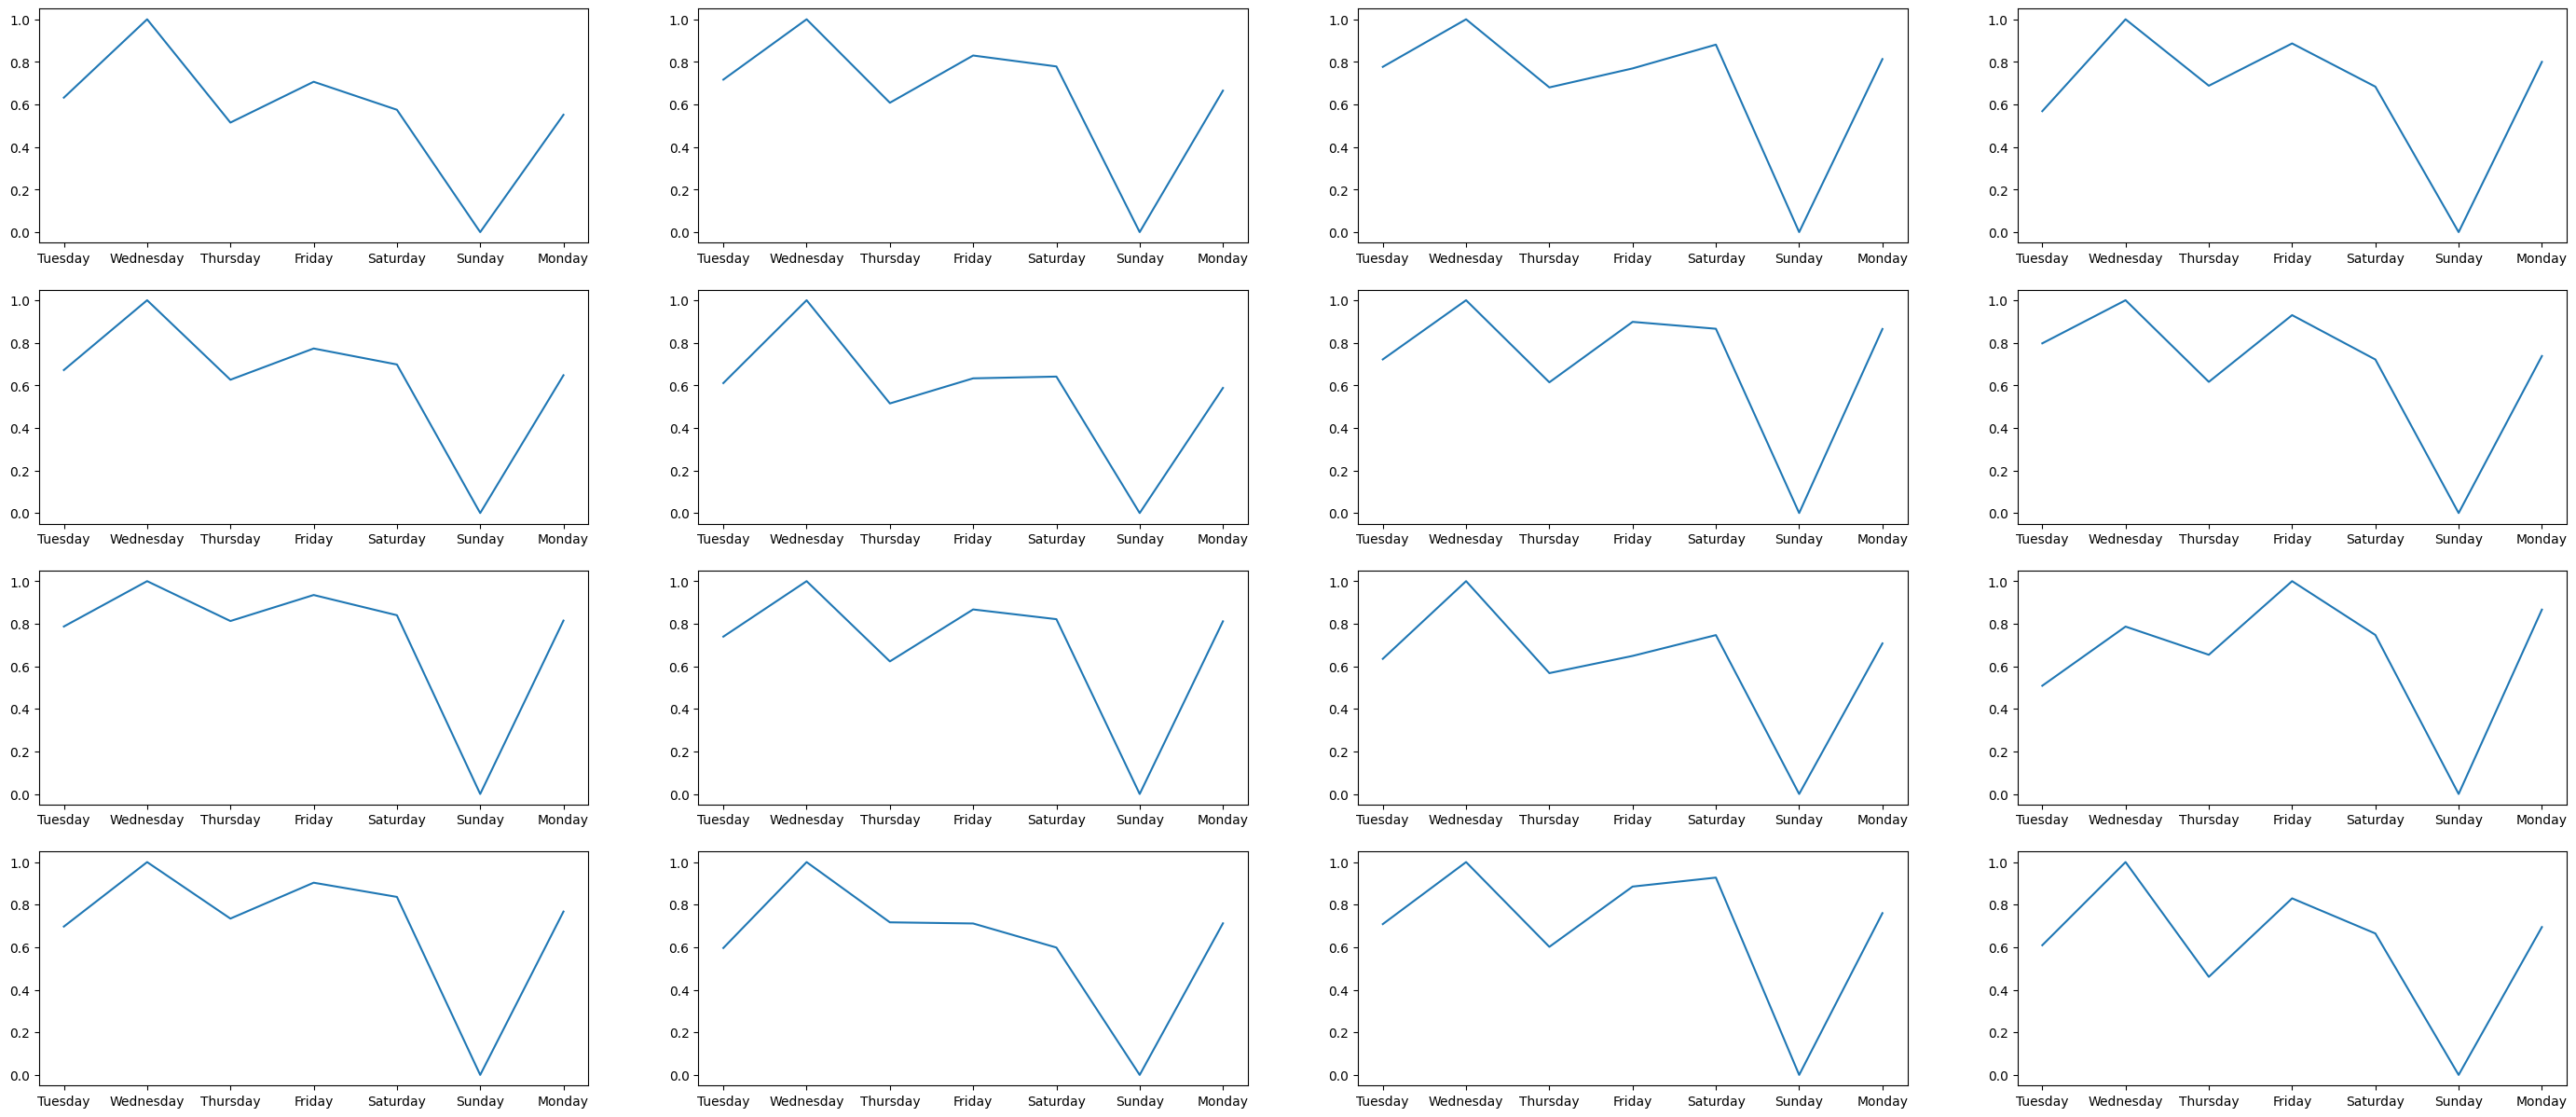

In [ ]:
#normal_data_graph
day = ['Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday','Monday']

fig, ax = plt.subplots(nrows=4, ncols=4, figsize=(35, 15))
for data,day,ax in zip(sample(normal_data,16),[day]*16,ax.flatten()):
  ax.plot(day,data)

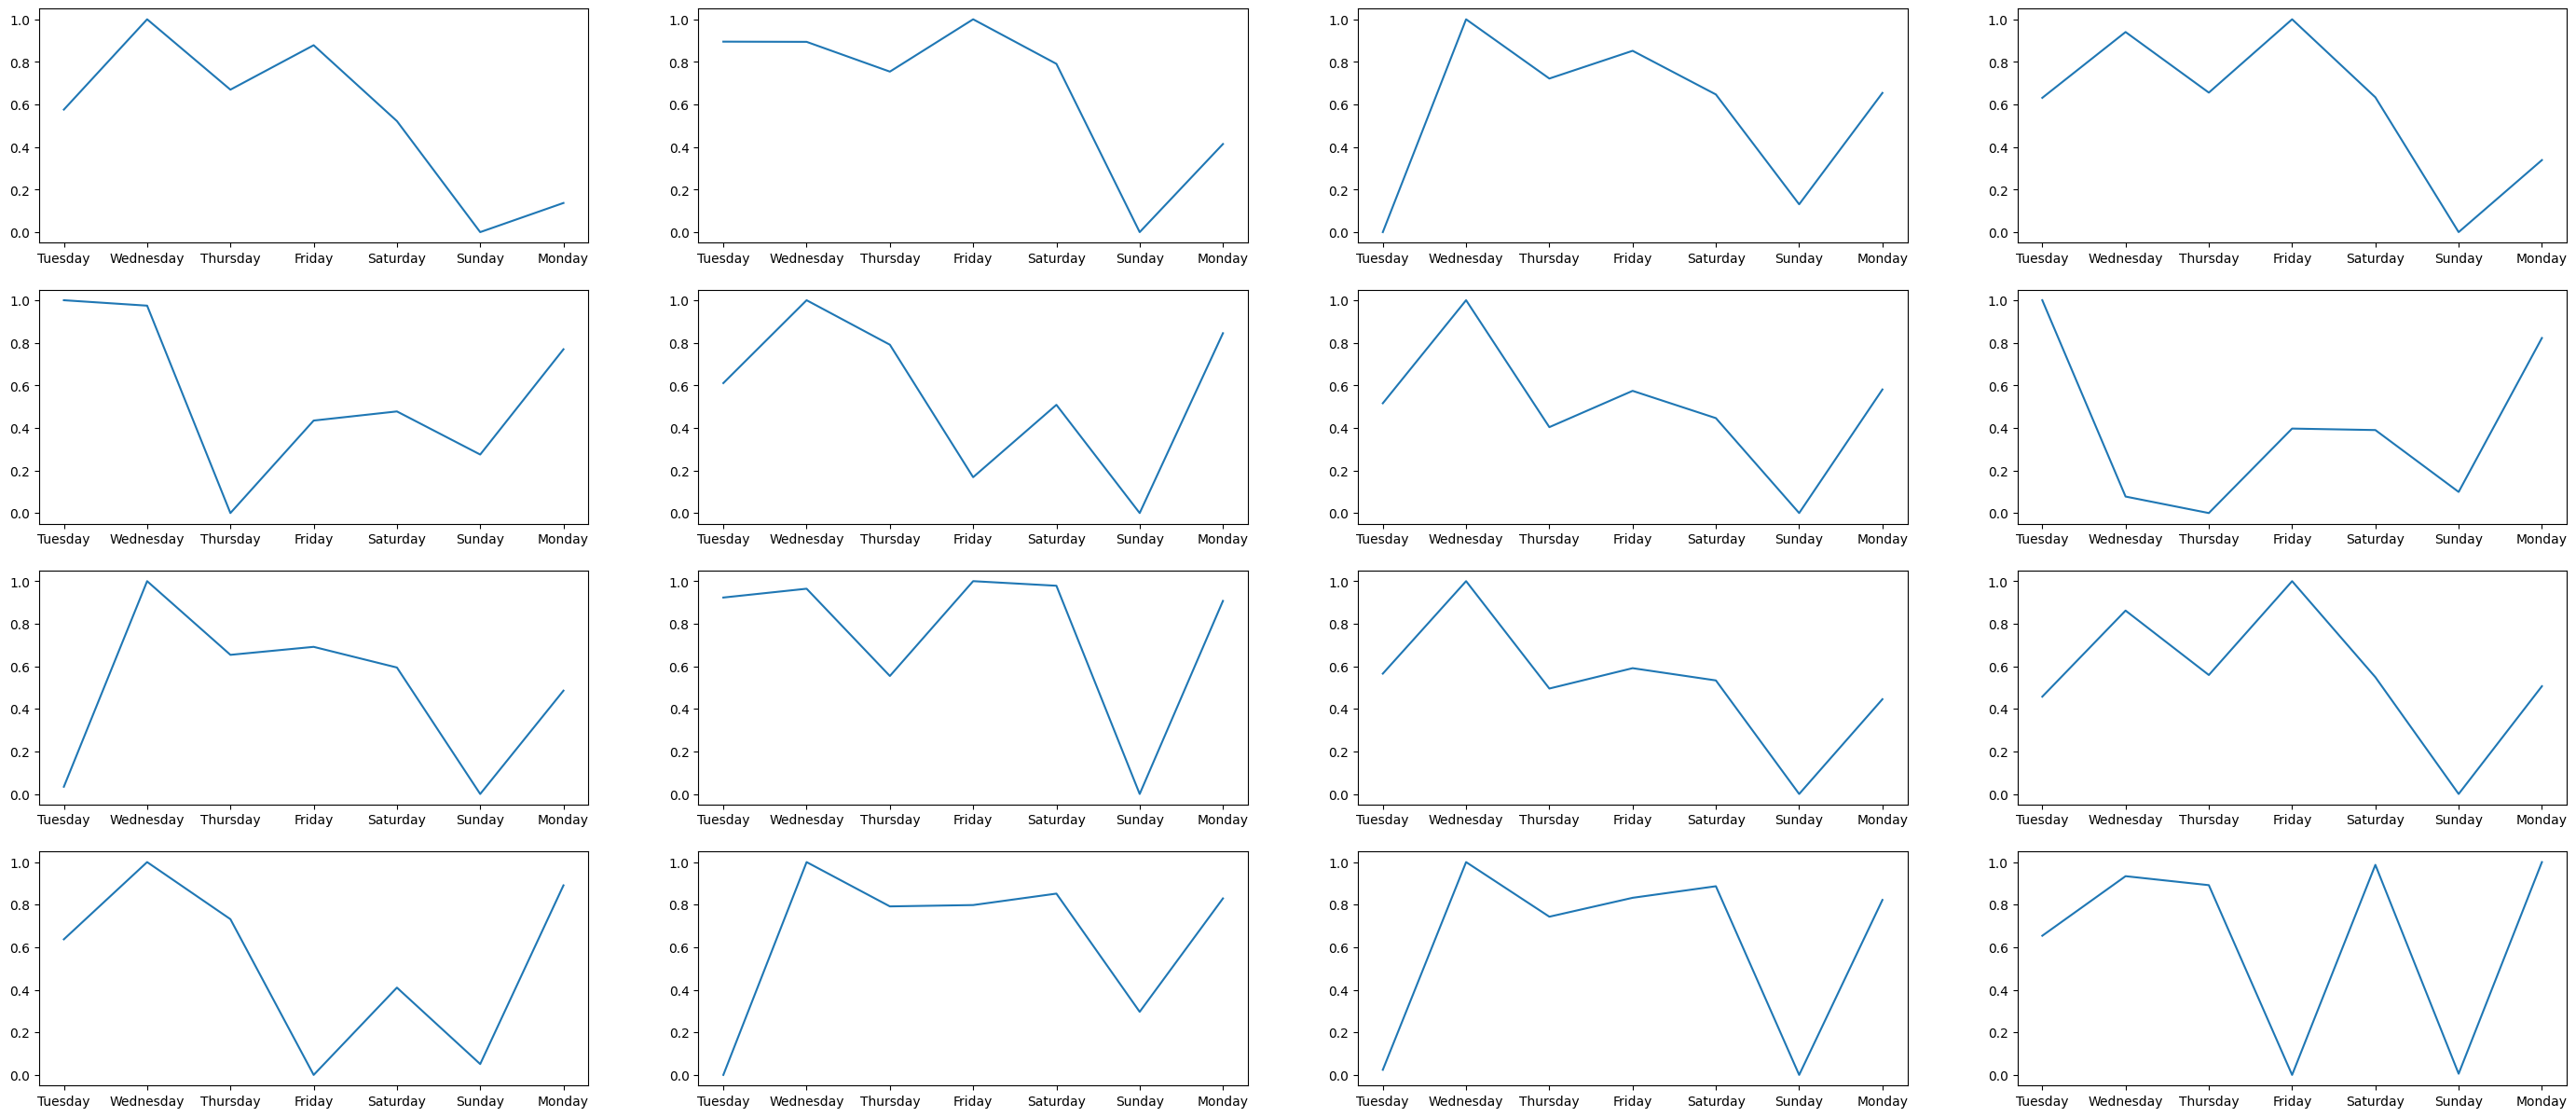

In [ ]:
from random import sample
#normal_data_graph
day = ['Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday','Monday']

fig, ax = plt.subplots(nrows=4, ncols=4, figsize=(35, 15))
for data,day,ax in zip(sample(abnormal_data,16),[day]*16,ax.flatten()):
  ax.plot(day,data)

In [ ]:
train, test = train_test_split(normal_data, test_size=0.3, random_state=42)

In [ ]:
train = tf.cast(train, tf.float32)
test = tf.cast(test, tf.float32)

In [ ]:
class AnomalyDetector(Model):
  def __init__(self):
    super(AnomalyDetector, self).__init__()
    self.encoder = tf.keras.Sequential([
        tf.keras.layers.Dense(16, activation="relu"),
        tf.keras.layers.Dense(8, activation="relu"),
        tf.keras.layers.Dense(2, activation="relu")
        ])

    self.decoder = tf.keras.Sequential([
        tf.keras.layers.Dense(8, activation="relu"),
        tf.keras.layers.Dense(16, activation="relu"),
        tf.keras.layers.Dense(7, activation="sigmoid")
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

In [ ]:
autoencoder = AnomalyDetector()

In [ ]:
autoencoder.compile(optimizer='adam', loss='mae')

In [ ]:
history = autoencoder.fit(train, train,
                          epochs=400,
                          batch_size=512,
                          validation_data=(test, test),
                          verbose=1,
                          shuffle=True)

Epoch 1/400
1/1 [==============================] - 2s 2s/step - loss: 0.3237 - val_loss: 0.3169
Epoch 2/400
1/1 [==============================] - 0s 35ms/step - loss: 0.3222 - val_loss: 0.3155
Epoch 3/400
1/1 [==============================] - 0s 34ms/step - loss: 0.3208 - val_loss: 0.3142
Epoch 4/400
1/1 [==============================] - 0s 35ms/step - loss: 0.3194 - val_loss: 0.3128
Epoch 5/400
1/1 [==============================] - 0s 35ms/step - loss: 0.3181 - val_loss: 0.3116
Epoch 6/400
1/1 [==============================] - 0s 48ms/step - loss: 0.3168 - val_loss: 0.3103
Epoch 7/400
1/1 [==============================] - 0s 33ms/step - loss: 0.3155 - val_loss: 0.3091
Epoch 8/400
1/1 [==============================] - 0s 37ms/step - loss: 0.3143 - val_loss: 0.3080
Epoch 9/400
1/1 [==============================] - 0s 37ms/step - loss: 0.3131 - val_loss: 0.3069
Epoch 10/400
1/1 [==============================] - 0s 55ms/step - loss: 0.3120 - val_loss: 0.3059
Epoch 11/400
1/1 [===

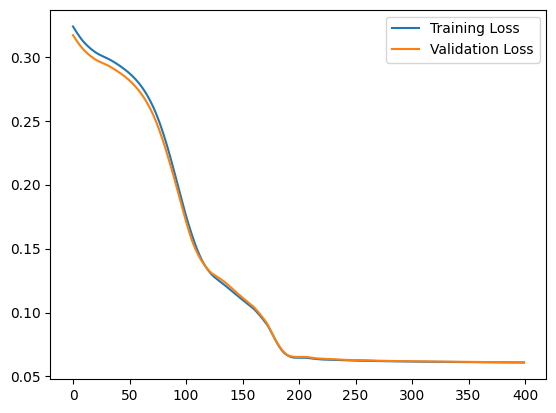

In [ ]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()

[0.69711107 1.         0.73454896 0.90315319 0.83635682 0.
 0.76745609]
[7.0883149e-01 9.9908072e-01 6.1966699e-01 8.8598651e-01 7.7758127e-01
 7.5803010e-04 7.5019956e-01]


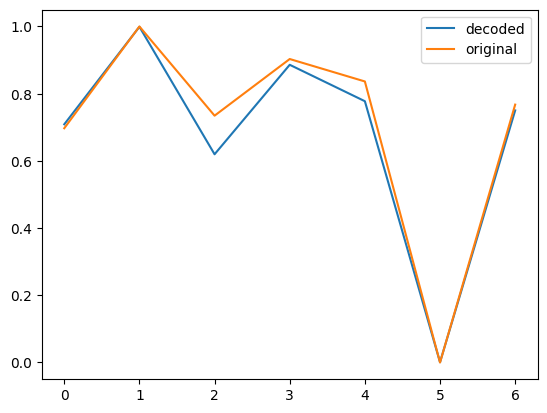

In [ ]:
#Check for certain week
test = 11

input_data = tf.reshape(full_data[test], (1, -1))

encoded_data = autoencoder.encoder(input_data).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy()

a = decoded_data[0]
b = full_data[test]

plt.plot(a, label='decoded')
plt.plot(b, label='original')
plt.legend()

In [ ]:
decoded_list =[]
for i in range(len(full_data)):
  input_data = tf.reshape(full_data[i], (1, -1))
  encoded_data = autoencoder.encoder(input_data).numpy()
  decoded_data = autoencoder.decoder(encoded_data).numpy()
  decoded_list.append(decoded_data[0])

In [ ]:
flatten_all_data = [y for i in full_data for y in i]
flatten_decoded_list = [y for i in decoded_list for y in i]

In [ ]:
error_ae = []
for i in range(len(flatten_all_data)):
  error_ae.append((flatten_all_data[i] - flatten_decoded_list[i])**2)

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=df_store.date[:1680],y=flatten_all_data,name='real'))
fig.add_trace(go.Scatter(x=df_store.date[:1680],y=flatten_decoded_list,name='reconstruct',fill='tonexty'))
fig.update_layout(title='Forecast vs Actual',
                  xaxis_title='Date',
                  yaxis_title='Sales')

fig.show()

#Anomalies Result

In [ ]:
threshold = np.mean(error_ae) + np.std(error_ae)
print(threshold)

0.11510791072192193


In [ ]:
threshold = 0.07
abnormal_indices = [i for i in range(len(error_ae)) if error_ae[i] > threshold]

abnormal_date = [df_store.date[i] for i in abnormal_indices]
abnormal_val = [df_store.sales[i] for i in abnormal_indices]

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=df_store.date[:1680],y=real,name='Real Data'))
fig.add_trace(go.Scatter(x=abnormal_date,y=abnormal_val,mode='markers',name='Anomalies'))

fig2 = go.Figure()
fig2.add_trace(go.Scatter(x=df_store.date[:1680],y=error_ae,name='Error'))
fig2.add_trace(go.Scatter(x=df_store.date[:1680],y=[threshold]*1680,name='Threshold'))

fig.show()
fig2.show()

In [ ]:
df_holiday = pd.read_csv("/content/holidays_events.csv")

In [ ]:
series = pd.Series(abnormal_date)
dates = pd.to_datetime(series, format='%Y%m%d')
abdate = dates.dt.strftime('%Y-%m-%d')

promotion_date = df[(df['onpromotion']!=0)&(df['date'].isin(abdate))]['date'].unique()
promotion_val = [df_store[df_store.date==i]['sales'].values[0] for i in promotion_date]

In [ ]:
holiday = df_holiday[df_holiday['date'].isin(abdate)]
holiday_date = holiday['date']
holiday_val = [df_store[df_store.date==i]['sales'].values[0] for i in holiday_date]

#Analysis Compare with Promotion and Holiday

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=df_store.date[:1680],y=real,name='Real Data'))
fig.add_trace(go.Scatter(x=abnormal_date,y=abnormal_val,mode='markers',name='Anomalies'))
fig.add_trace(go.Scatter(x=promotion_date,y=promotion_val,mode='markers',name='Promotion'))
fig.add_trace(go.Scatter(x=holiday_date,y=holiday_val,mode='markers',name='Holiday'))
fig.show()